# Modelos Long-Short Term Memory 

Laboratorio 02 – Series de Tiempo con Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119 - Diego García 22404

Para este laboratorio trabajaremos con las series Regular_Imp y Diesel_Con ya que ambas series fueron completamente modeladas y analizadas en el laboratorio 1 además de su disponibilidad de datos adecuados para LSTM.

### Librerías necesarias

In [34]:
import numpy as np
import pandas as pd
import warnings
import os
import math
import matplotlib.pyplot as plt
# pip install tensorflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime los logs innecesarios de TensorFlow
warnings.filterwarnings('ignore')         # Suprime los warnings de Python

### Preprocesamiento

##### Cargar el dataset correctamente

In [35]:
df = pd.read_csv("../data/clean/Series_de_Tiempo_Combustibles.csv", parse_dates=["fecha"])
df = df.sort_values("fecha")
df.set_index("fecha", inplace=True)
df.head()

,Regular_Imp,Superior_Imp,Diesel_Imp,Regular_Con,Superior_Con,Diesel_Con
fecha,,,,,,
2000-01-01,NaN,NaN,NaN,202645.20,308156.82,634667.06
2000-02-01,NaN,NaN,NaN,205530.96,307766.31,642380.66
2000-03-01,NaN,NaN,NaN,229499.56,331910.29,699807.25
2000-04-01,NaN,NaN,NaN,210680.40,315648.08,586803.98
2000-05-01,NaN,NaN,NaN,208164.34,319667.97,656948.20


##### Visualización Exploratoria de las Series Temporales

Se grafican las series originales de importación y consumo de combustibles sin aplicar aún ningún filtro o limpieza. Esto para poder identificar tendencias, patrones y posibles problemas en los datos (como valores nulos o ceros).

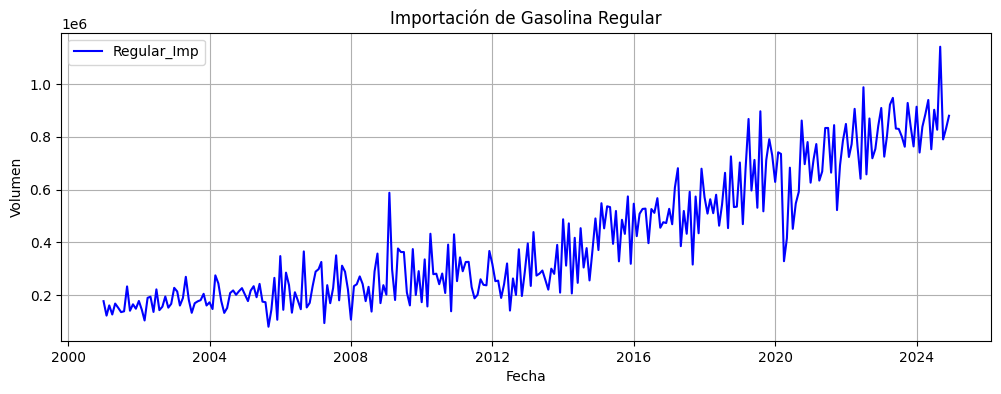

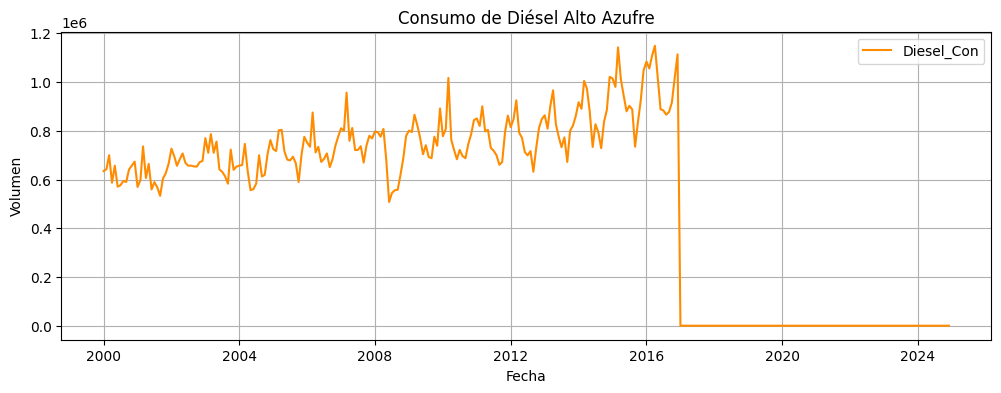

In [36]:
# Series seleccionadas
regular_imp = df["Regular_Imp"].dropna()
diesel_con = df["Diesel_Con"].dropna()

# Graficar Regular_Imp
plt.figure(figsize=(12, 4))
plt.plot(regular_imp, label="Regular_Imp", color='blue')
plt.title("Importación de Gasolina Regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid()
plt.legend()
plt.show()

# Graficar Diesel_Con
plt.figure(figsize=(12, 4))
plt.plot(diesel_con, label="Diesel_Con", color='darkorange')
plt.title("Consumo de Diésel Alto Azufre")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid()
plt.legend()
plt.show()


**Observaciones:**
- La serie `Regular_Imp` muestra una tendencia creciente constante, ideal para modelado con LSTM.
- La serie `Diesel_Con` se interrumpe drásticamente en 2017, a partir de esa fecha todos los valores son cero.

##### Preprocesamiento de Datos para Modelado LSTM

Se seleccionan y limpian las series relevantes para el modelado. En el caso de `Diesel_Con`, se recorta hasta 2017 para evitar valores nulos o ceros que afecten el entrenamiento. También se eliminan valores nulos en `Regular_Imp`.

In [37]:
# Filtrar Diesel_Con eliminando los ceros finales
diesel_con = diesel_con[diesel_con > 0]

# Escalar ambas series
scaler_reg = MinMaxScaler()
scaler_diesel = MinMaxScaler()

regular_scaled = scaler_reg.fit_transform(regular_imp.values.reshape(-1, 1))
diesel_scaled = scaler_diesel.fit_transform(diesel_con.values.reshape(-1, 1))

# Separar 80% entrenamiento y 20% prueba
def split_data(series_scaled, train_ratio=0.8):
    n = len(series_scaled)
    train_size = int(n * train_ratio)
    return series_scaled[:train_size], series_scaled[train_size:]

train_reg, test_reg = split_data(regular_scaled)
train_diesel, test_diesel = split_data(diesel_scaled)

# Función para crear secuencias LSTM
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 meses (1 año)

X_reg, y_reg = create_sequences(train_reg, window_size)
X_reg_test, y_reg_test = create_sequences(test_reg, window_size)

X_diesel, y_diesel = create_sequences(train_diesel, window_size)
X_diesel_test, y_diesel_test = create_sequences(test_diesel, window_size)

# Confirmar formas
print("Regular:", X_reg.shape, y_reg.shape)
print("Diesel:", X_diesel.shape, y_diesel.shape)


Regular: (218, 12, 1) (218, 1)
Diesel: (151, 12, 1) (151, 1)


### Modelo LSTM 1 - Importación de Gasolina Regular

##### Escalamiento y generación de secuencias

In [38]:
# Escalar los datos de Regular_Imp
scaler_reg = MinMaxScaler()
regular_scaled = scaler_reg.fit_transform(regular_imp.values.reshape(-1, 1))

# Separar en entrenamiento y prueba (80% entrenamiento)
train_size = int(len(regular_scaled) * 0.8)
train_data = regular_scaled[:train_size]
test_data = regular_scaled[train_size:]

##### Ventanas de tiempo

In [39]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Ventanas de 12 meses (1 año)
window_size = 12
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (218, 12, 1) y_train: (218, 1)
X_test: (46, 12, 1) y_test: (46, 1)


##### Construcción modelo LSTM

In [40]:
# Definir modelo
model_reg = Sequential()
model_reg.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model_reg.add(Dense(1))  # salida univariada

# Compilar modelo
model_reg.compile(optimizer='adam', loss='mse')

# Entrenar modelo
history = model_reg.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0593 - val_loss: 0.0100
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - val_loss: 0.0265
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0101
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0148
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0154
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0110
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0135
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0117
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0097
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0152
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

##### Visualización del loss

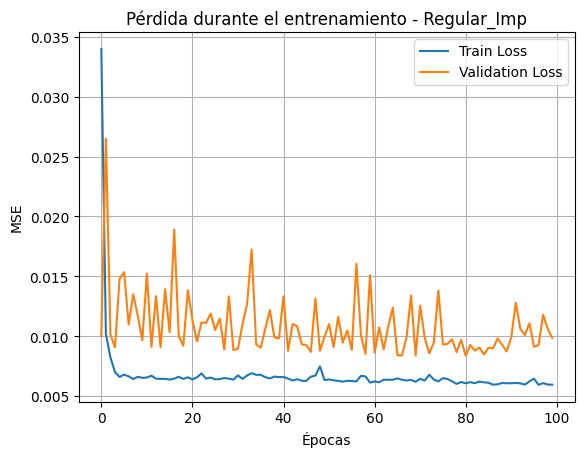

In [41]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Pérdida durante el entrenamiento - Regular_Imp")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

### Modelo 2 LSTM Gasolina Regular 

In [ ]:
from tensorflow.keras.optimizers import Adam

# ==== Regular_Imp –: stacked LSTM + Dropout ====
model_reg2 = Sequential()
model_reg2.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(window_size, 1)))
model_reg2.add(Dropout(0.2))
model_reg2.add(LSTM(32, activation='tanh'))
model_reg2.add(Dense(1))
model_reg2.compile(optimizer=Adam(learning_rate=9.5e-4), loss='mse')

es_reg2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_reg2 = model_reg2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[es_reg2],
    verbose=1
)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0354 - val_loss: 0.0105
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0477
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0110
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0094
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0153
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0114
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0127
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [43]:
models_reg["LSTM64_32_w12_do02"]   = model_reg2

### Modelo LSTM 2 - Consumo de Diesel

##### Preparar la serie

In [44]:
# Escalar los datos de Diesel_Con
scaler_diesel = MinMaxScaler()
diesel_scaled = scaler_diesel.fit_transform(diesel_con.values.reshape(-1, 1))

# Separar en entrenamiento y prueba
train_size_d = int(len(diesel_scaled) * 0.8)
train_diesel = diesel_scaled[:train_size_d]
test_diesel = diesel_scaled[train_size_d:]

##### Secuencias

In [45]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12  # un año

X_train_diesel, y_train_diesel = create_sequences(train_diesel, window_size)
X_test_diesel, y_test_diesel = create_sequences(test_diesel, window_size)

print("X_train_diesel:", X_train_diesel.shape, "y_train_diesel:", y_train_diesel.shape)
print("X_test_diesel:", X_test_diesel.shape, "y_test_diesel:", y_test_diesel.shape)

X_train_diesel: (151, 12, 1) y_train_diesel: (151, 1)
X_test_diesel: (29, 12, 1) y_test_diesel: (29, 1)


##### Construcción del LSTM

In [46]:
model_diesel = Sequential()
model_diesel.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model_diesel.add(Dense(1))

# Compilar modelo
model_diesel.compile(optimizer='adam', loss='mse')

# Entrenar modelo
history_diesel = model_diesel.fit(
    X_train_diesel, y_train_diesel,
    validation_data=(X_test_diesel, y_test_diesel),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0936 - val_loss: 0.0836
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0352
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - val_loss: 0.0657
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0518
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0485
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 - val_loss: 0.0522
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - val_loss: 0.0517
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - val_loss: 0.0521
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - val_loss: 0.0453
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - val_loss: 0.0526
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 - val_loss: 0.0539
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

##### Visualización

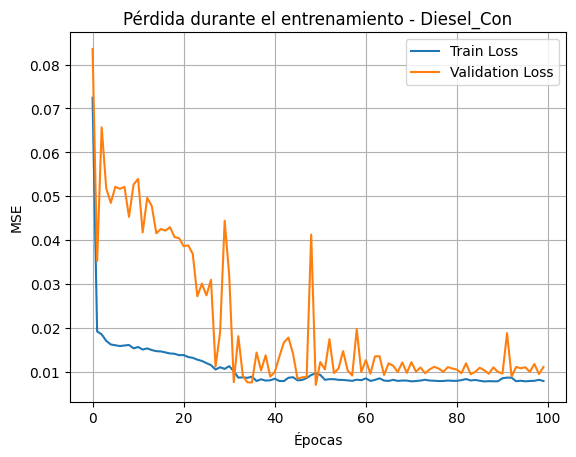

In [47]:
plt.plot(history_diesel.history['loss'], label='Train Loss')
plt.plot(history_diesel.history['val_loss'], label='Validation Loss')
plt.title("Pérdida durante el entrenamiento - Diesel_Con")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()


### Modelo 2 LSTM Gasolina Diesel 

In [ ]:
# ==== Diesel_Con –: más unidades + Dropout ====
model_diesel2 = Sequential()
model_diesel2.add(LSTM(96, activation='tanh', return_sequences=False, input_shape=(window_size, 1)))
model_diesel2.add(Dropout(0.2))
model_diesel2.add(Dense(1))
model_diesel2.compile(optimizer=Adam(learning_rate=8e-4), loss='mse')

es_diesel2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_diesel2 = model_diesel2.fit(
    X_train_diesel, y_train_diesel,
    validation_data=(X_test_diesel, y_test_diesel),
    epochs=200,
    batch_size=16,
    callbacks=[es_diesel2],
    verbose=1
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1032 - val_loss: 0.0708
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239 - val_loss: 0.0377
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201 - val_loss: 0.0769
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - val_loss: 0.0560
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0462
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - val_loss: 0.0571
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - val_loss: 0.0516
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0184 - val_loss: 0.0551
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0558
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0470
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0197 - val_loss: 0.0549
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [49]:
models_diesel["LSTM96_w12_do02"] = model_diesel2